In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import getpass
username = getpass.getuser()

import sys
sys.path.append('/Users/{:}/GitHub/mouse_bandit/data_preprocessing_code'.format(username))
sys.path.append('/Users/{:}/GitHub/mouse_bandit'.format(username))
import support_functions as sf

sys.path.append('/Users/{:}/GitHub/mouse_bandit/jupyter_notebooks/helper_functions'.format(username))
import bandit_modeling as bm

% matplotlib inline

In [2]:
data = pd.read_csv('/Users/{:}/Dropbox (HMS)/mouse_bandit/markov_full.csv'.format(username), index_col=0)
#data = data[data['Condition']=='70-30']

### lr1 - train on port choice to predict port choice
#### Evaluate performance on predicting choice and predicting switches
#### Inputs:
#### 1=left, rewarded
####     -1=right, rewarded
####      0=left/right, unrewarded

In [33]:
X, y, c = bm.feature_history(data, X_dataframe='choice', y_dataframe='choice')
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y, c, test_size=0.3, random_state=1)

lr1_choice = LogisticRegression()
lr1_choice.fit(X_train, y_train)

lr1_choice_proba = lr1_choice.predict_proba(X_test)
lr1_choice_predict = lr1_choice.predict(X_test)

score_lr1_choice = lr1_choice.score(X_test, y_test)
metrics_lr1_choice = sklearn.metrics.precision_recall_fscore_support(y_test, lr1_choice_predict)

prev_choice = c_test['1_Port']
true_switch = (y_test!=prev_choice).astype('int')
lr1_switch_predict = (lr1_choice_predict!=prev_choice).astype('int')
metrics_lr1_switch = sklearn.metrics.precision_recall_fscore_support(true_switch, lr1_switch_predict)

#acc_pos,acc_neg,F1=sf.score_both_and_confuse(lr1_switch_predict,Y_test_switch,confusion=False,disp=True)

In [34]:
metrics_lr1_switch

(array([ 0.94651914,  0.43631724]),
 array([ 0.97090235,  0.29106383]),
 array([ 0.95855571,  0.34918744]),
 array([91107,  7050]))

In [35]:
acc_pos,acc_neg,F1=sf.score_both_and_confuse(lr1_switch_predict.values,true_switch.values,confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO        88456.0         2651.0
True YES        4998.0         2052.0

F1: 0.349

Accuracy on class 0: 0.97
Accuracy on class 1: 0.29



/Users/celiaberon/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


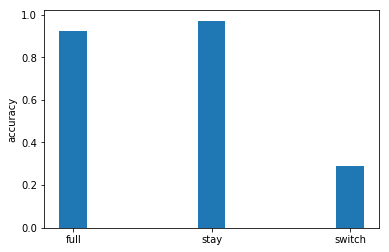

In [36]:
height_a = [score_lr1_choice, metrics_lr1_switch[1][0], metrics_lr1_switch[1][1]]

barWidth = 0.2
# The x position of bars
r1 = np.arange(len(height_a))

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth)

plt.xticks(range(len(height_a)), conditions)
plt.ylabel('accuracy')
plt.legend()

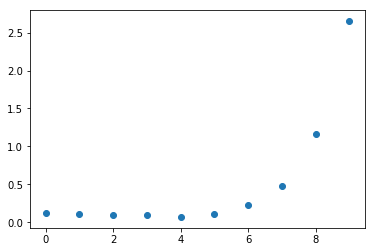

In [37]:
plt.scatter(np.arange(lr1_choice.coef_.shape[1]),lr1_choice.coef_)

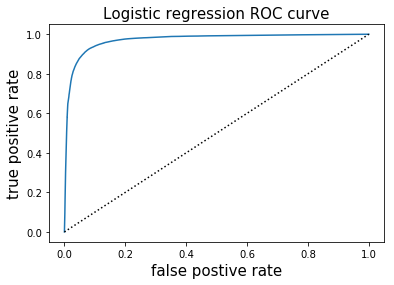

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, lr1_choice_proba[:,1])
plt.plot(fpr, tpr, label="LR1_PORT")

plt.plot([0, 1], [0, 1], ':k')
plt.xlabel('false postive rate', size=15)
plt.ylabel('true positive rate', size=15)
plt.title('Logistic regression ROC curve', size=15)

### lr2 - train on switches to predict switches

In [8]:
X, y, c = bm.feature_history(data, X_dataframe='switch', y_dataframe='switch')
# redefine training and testing sets to use switch history and current switch decision
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# train and test LR
lr2_switch = LogisticRegression()
lr2_switch.fit(X_train, y_train)

lr2_switch_proba = lr2_switch.predict_proba(X_test)
lr2_switch_predict = lr2_switch.predict(X_test)

score_lr2_switch = lr2_switch.score(X_test, y_test)
metrics_lr2_switch = sklearn.metrics.precision_recall_fscore_support(y_test, lr2_switch_predict)


In [11]:
metrics_lr2_switch

(array([ 0.9281666 ,  0.05454545]),
 array([  9.99429243e-01,   4.25531915e-04]),
 array([  9.62480643e-01,   8.44475721e-04]),
 array([91107,  7050]))

In [23]:
acc_pos,acc_neg,F1=sf.score_both_and_confuse(lr2_switch_predict, y_test.values, confusion=False, disp=True)

          Predicted NO  Predicted YES
True NO            0.0            0.0
True YES           0.0            3.0

F1: 1.000

Accuracy on class 0: nan
Accuracy on class 1: 0.00



/Users/celiaberon/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/celiaberon/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
test = lr2_switch_proba[:,1]>0.2
sklearn.metrics.precision_recall_fscore_support(y_test, test)

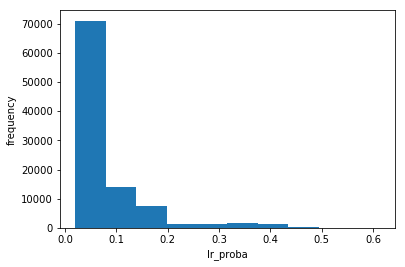

In [12]:
plt.hist(lr2_switch_proba[:,1])
plt.xlabel('lr_proba')
plt.ylabel('frequency')

### lr2.1 - change decision boundary

In [ ]:
metrics_db = []
decision_boundaries = np.arange(0.05,0.6,0.05)
for boundary in decision_boundaries:
    temp_predict = lr2_switch_proba[:,1]>boundary
    metrics_temp = sklearn.metrics.precision_recall_fscore_support(y_test, temp_predict)
    metrics_db.append(metrics_temp)

In [ ]:
decision_boundaries

In [ ]:
metrics_db

In [ ]:
y_predict = lr2_switch_proba[:,1] > 0.2

score_switch_2 = 1-(np.sum(np.abs(y_predict - y_test)) / (len(y_test)))
#switch_predict_2 = np.abs([y_predict[n,1] - X_test[n,8] for n in range(len(y_predict))])

metrics_switch_3 = sklearn.metrics.precision_recall_fscore_support(y_test, y_predict)


In [ ]:
height_a = [score_lr1_choice, metrics_lr1_switch[1][0], metrics_lr1_switch[1][1]]
height_b = [score_lr2_switch, metrics_lr2_switch[1][0], metrics_lr2_switch[1][1]]
height_c = [score_switch_2, metrics_switch_3[1][0], metrics_switch_3[1][1]]

barWidth = 0.3
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='lr_choice')
plt.bar(r2, height_b, width=barWidth, label='lr_switch')
plt.bar(r3, height_c, width=barWidth, label='lr_switch, db=.1')
plt.xticks(range(len(height_b)), conditions)
plt.ylabel('accuracy (f1)')
plt.legend()

### lr3 - use action value to predict choice

In [ ]:
X, y = bm.Xy_history(data, X_dataframe='value', y_dataframe='choice')

# redefine training set to use value history
X_train, X_test, y_train, y_test_choice = train_test_split(X, y, test_size=0.3, random_state=1)

# train and test LR
lr3_value = LogisticRegression()
lr3_value.fit(X_train, y_train)

lr3_value_proba = lr3_value.predict_proba(X_test)
lr3_value_predict = lr3_value.predict(X_test)

score_lr3_value_choice = lr3_value.score(X_test, y_test_choice)
metrics_lr3_value = sklearn.metrics.precision_recall_fscore_support(y_test_choice, lr3_value_predict)

lr3_switch_predict = np.abs(lr3_value_predict-prev_choice)
#lr3_switch_predict = np.abs([lr3_value_predict[n] - X_test[n,8] for n in range(len(lr3_value_predict))])
metrics_lr3_switch = sklearn.metrics.precision_recall_fscore_support(y_test_choice, lr3_switch_predict)

#score_switch_2 = 1-(np.sum([np.abs(lr3_value_predict[i] - Y_test_switch[i]) for i in range(len(Y_test_switch))])/(len(Y_test_switch)))


### what about a logistic regression with more inputs?

In [ ]:
X, y = bm.Xy_history(data, X_dataframe='choice_switch', y_dataframe='choice')
#train on proportion of data up to the 'cutoff.' hold out the rest as test data.
X_train, X_test, y_train, y_test_choice = train_test_split(X, y, test_size=0.3, random_state=1)

# train and test LR
lr4_multi = LogisticRegression()
lr4_multi.fit(X_train, y_train)

lr4_multi_proba = lr4_multi.predict_proba(X_test)
lr4_multi_predict = lr4_multi.predict(X_test)

score_lr4_multi_choice = lr4_multi.score(X_test, y_test_choice)
metrics_lr4_choice = sklearn.metrics.precision_recall_fscore_support(y_test_choice, lr4_multi_predict)

lr4_switch_predict = np.abs(lr4_multi_predict-prev_choice)
#lr4_switch_predict = np.abs([lr4_multi_predict[n] - X_test[n,8] for n in range(len(lr4_multi_predict))])
metrics_lr4_switch = sklearn.metrics.precision_recall_fscore_support(true_switch, lr4_switch_predict)

#score_switch_2 = 1-(np.sum([np.abs(lr4_multi_predict[i] - Y_test_switch[i]) for i in range(len(Y_test_switch))])/(len(Y_test_switch)))

'''
Now train to predict switches
'''

X, y = bm.Xy_history(data, X_dataframe='choice_switch', y_dataframe='switch')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

lr5_multi = LogisticRegression()
lr5_multi.fit(X_train, y_train)

lr5_multi_proba = lr5_multi.predict_proba(X_test)
lr5_multi_predict = lr5_multi.predict(X_test)

score_lr5_multi_switch = lr5_multi.score(X_test, y_test)
metrics_lr5_switch = sklearn.metrics.precision_recall_fscore_support(y_test, lr5_multi_predict)


## F1 score

In [ ]:
height_a = [score_lr1_choice, metrics_lr1_switch[2][0], metrics_lr1_switch[2][1]]
height_b = [score_lr2_switch, metrics_lr2_switch[2][0], metrics_lr2_switch[2][1]]
#height_c = [score_lr3_value_choice, metrics_lr3_switch[2][0], metrics_lr3_switch[2][1]]
#height_d = [score_lr4_multi_choice, metrics_lr4_switch[2][0], metrics_lr4_switch[2][1]]
#height_e = [score_lr5_multi_switch, metrics_lr5_switch[2][0], metrics_lr5_switch[2][1]]

barWidth = 0.1
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
#r3 = [x + barWidth for x in r2]
#r4 = [x + barWidth for x in r3]
#r5 = [x + barWidth for x in r4]

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='lr1_choice')
plt.bar(r2, height_b, width=barWidth, label='lr2_switch')
#plt.bar(r3, height_c, width=barWidth, label='lr3_value')
#plt.bar(r4, height_d, width=barWidth, label='lr4_multi_choice')
#plt.bar(r5, height_e, width=barWidth, label='lr5_multi_switch')

plt.xticks(range(len(height_b)), conditions)
plt.ylabel('f1')
plt.legend()

## Accuracy/recall
### predicted switches/stays out of total true switches/stays

In [ ]:
height_a = [score_lr1_choice, metrics_lr1_switch[1][0], metrics_lr1_switch[1][1]]
height_b = [score_lr2_switch, metrics_lr2_switch[1][0], metrics_lr2_switch[1][1]]
height_c = [score_lr3_value_choice, metrics_lr3_switch[1][0], metrics_lr3_switch[1][1]]
height_d = [score_lr4_multi_choice, metrics_lr4_switch[1][0], metrics_lr4_switch[1][1]]
height_e = [score_lr5_multi_switch, metrics_lr5_switch[1][0], metrics_lr5_switch[1][1]]

barWidth = 0.2
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='lr1_choice')
plt.bar(r2, height_b, width=barWidth, label='lr2_switch')
plt.bar(r3, height_c, width=barWidth, label='lr3_value')
#plt.bar(r4, height_d, width=barWidth, label='lr4_multi_choice')
#plt.bar(r5, height_e, width=barWidth, label='lr5_multi_switch')

plt.xticks(range(len(height_b)), conditions)
plt.ylabel('accuracy')
plt.legend()

In [ ]:
lr1_choice.coef_.shape

In [ ]:
np.arange(lr1_choice.coef_.shape[1]/-2,0)

In [ ]:
plt.plot(np.arange(lr1_choice.coef_.shape[1]/-1,0), lr1_choice.coef_[0][0:int(lr1_choice.coef_.shape[1])])



In [ ]:
plt.plot(np.arange(lr1_choice.coef_.shape[1]/-2,0), lr1_choice.coef_[0][0:int(lr1_choice.coef_.shape[1]/2)])
plt.plot(np.arange(lr1_choice.coef_.shape[1]/-2,0), lr1_choice.coef_[0][int(lr1_choice.coef_.shape[1]/2):])

In [ ]:
plt.plot(np.arange(lr2_switch.coef_.shape[1]/-2,0), lr2_switch.coef_[0][0:int(lr1_choice.coef_.shape[1]/2)])
plt.plot(np.arange(lr2_switch.coef_.shape[1]/-2,0), lr2_switch.coef_[0][int(lr1_choice.coef_.shape[1]/2):])

In [ ]:
plt.plot(np.arange(lr3_value.coef_.shape[1]/-1,0), lr3_value.coef_[0][0:int(lr3_value.coef_.shape[1])])


In [ ]:
#X, y = bm.Xy_history(data, X_dataframe='choice', y_dataframe='choice')
#X_train, X_test, y_train, y_test_choice = train_test_split(X, y, test_size=0.3, random_state=1)

lr1_choice = LogisticRegression()
lr1_choice.fit(X_train, y_train)

lr1_choice_proba = lr1_choice.predict_proba(X_test)
lr1_choice_predict = lr1_choice.predict(X_test)

score_lr1_choice = lr1_choice.score(X_test, y_test_choice)
metrics_lr1_choice = sklearn.metrics.precision_recall_fscore_support(y_test_choice, lr1_choice_predict)

prev_choice = c_test['1_Port']
true_switch = np.abs(y_test_choice-prev_choice)
lr1_switch_predict = np.abs(lr1_choice_predict-prev_choice)
metrics_lr1_switch = sklearn.metrics.precision_recall_fscore_support(true_switch, lr1_switch_predict)



In [ ]:
metrics_lr1_switch

In [ ]:
height_a = [score_lr1_choice, metrics_lr1_switch[1][0], metrics_lr1_switch[1][1]]

barWidth = 0.2
# The x position of bars
r1 = np.arange(len(height_a))

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='lr1_choice')

plt.xticks(range(len(height_a)), conditions)
plt.ylabel('accuracy')
plt.legend()

In [ ]:
port_features = []
reward_features = []
for col in data.columns:
    if '_Port' in col:
        port_features.append(col)
    if '_Reward' in col:
        reward_features.append(col)

choice_raw = data[port_features] # choice history
c = choice_raw.copy()
c[choice_raw==0]=-1 # make right choice -1 instead of zero (important for making final dataframe)
r = data[reward_features] # reward history
    
d = c.values * r.values # now only have 1 where left choice was rewarded, -1 where right choice was rewarded

In [ ]:
switch_cols = ['9_Switch','8_Switch','7_Switch','6_Switch','5_Switch','4_Switch','3_Switch','2_Switch','1_Switch']
switch_raw = pd.DataFrame(np.abs(np.diff((choice_raw))))
switch_raw.columns=switch_cols
switch_raw.index=r.index

In [ ]:
s = switch_raw.copy()
s[switch_raw==0]=-1

In [ ]:
r=r.drop('10_Reward', axis=1)

In [ ]:
np.unique(s.values*r.values)

In [ ]:
#r=r.drop('10_Reward',axis=1)
d = s.values * r.values

y = data['Switch']
y[y==0]=-1

In [ ]:
#X, y = bm.Xy_history(data, X_dataframe='choice', y_dataframe='choice')
X_train, X_test, y_train, y_test_choice, s_train, s_test = train_test_split(s, y, s, test_size=0.3, random_state=1)

lr1_choice = LogisticRegression()
lr1_choice.fit(X_train, y_train)

lr1_choice_proba = lr1_choice.predict_proba(X_test)
lr1_choice_predict = lr1_choice.predict(X_test)

score_lr1_choice = lr1_choice.score(X_test, y_test_choice)
metrics_lr1_choice = sklearn.metrics.precision_recall_fscore_support(y_test_choice, lr1_choice_predict)

prev_choice = c_test['1_Port']
true_switch = np.abs(y_test_choice-prev_choice)
lr1_switch_predict = np.abs(lr1_choice_predict-prev_choice)
metrics_lr1_switch = sklearn.metrics.precision_recall_fscore_support(true_switch, lr1_switch_predict)

In [ ]:
metrics_lr1_choice